In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import datetime
from sklearn.model_selection import TimeSeriesSplit

In [12]:
# Load the dataset
df = pd.read_csv('TSLA.csv')

end_date = datetime.datetime.now() 
start_date = end_date - datetime.timedelta(days = 365 * 5)
stock_data = yf.download('TSLA', start=start_date.date(), end=end_date.date())

# Use only the 'Close' column
data = pd.DataFrame(stock_data[['Open', 'Close', 'High', 'Low']].values, columns=['Open', 'Close', 'High', 'Low'])

n_periods = 5
sma = data['Close'].rolling(window=n_periods).mean()
data['SMA'] = sma

short_ema = data['Close'].ewm(span=12, adjust=False).mean()
long_ema = data['Close'].ewm(span=26, adjust=False).mean()

macd_line = short_ema - long_ema
signal_line = macd_line.ewm(span=9, adjust=False).mean()
macd_histogram = macd_line - signal_line

data['MACD'] = macd_line
data['Signal_Line'] = signal_line
data['MACD_Histogram'] = macd_histogram
data.dropna(inplace=True)
print(data.head)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 1])
    return np.array(dataX), np.array(dataY)

# Define time step and split data
time_step = 100
X, y = create_dataset(scaled_data, time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# Reshape input to be [samples, time steps, features]
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 8)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 8)

[*********************100%***********************]  1 of 1 completed
<bound method NDFrame.head of             Open       Close        High         Low         SMA      MACD  \
4      17.990667   18.330667   18.406668   17.740667   18.794800 -0.162883   
5      18.512667   18.213333   18.743999   18.029333   18.581733 -0.209257   
6      18.110001   18.153999   18.333332   17.974001   18.400800 -0.247938   
7      18.449333   18.403999   18.558666   18.192667   18.190800 -0.255475   
8      17.886667   17.894667   18.033333   17.706667   18.199333 -0.299100   
...          ...         ...         ...         ...         ...       ...   
1253  166.690002  170.830002  171.199997  166.300003  172.886005 -7.029195   
1254  168.759995  172.630005  175.240005  168.729996  172.652005 -6.656483   
1255  178.580002  177.669998  184.250000  177.380005  173.922003 -5.886564   
1256  181.410004  179.830002  181.910004  176.000000  174.756003 -5.043960   
1257  177.449997  175.789993  179.570007  1

In [13]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

train_indices = []
test_indices = []

for train_index, test_index in tscv.split(X_train):
    train_indices.append(train_index)
    test_indices.append(test_index)

for i in range(n_splits):
    X_train_fold, X_val_fold = X_train[train_indices[i]], X_train[test_indices[i]]
    y_train_fold, y_val_fold = y_train[train_indices[i]], y_train[test_indices[i]]

In [14]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(100, 8)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_val_fold, y_val_fold))

Epoch 1/100
15/15 [==============================] - 19s 406ms/step - loss: 0.0599 - val_loss: 0.0098
Epoch 2/100
15/15 [==============================] - 3s 223ms/step - loss: 0.0076 - val_loss: 0.0036
Epoch 3/100
15/15 [==============================] - 3s 227ms/step - loss: 0.0040 - val_loss: 0.0062
Epoch 4/100
15/15 [==============================] - 3s 201ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 5/100
15/15 [==============================] - 3s 190ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 6/100
15/15 [==============================] - 3s 210ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 7/100
15/15 [==============================] - 3s 227ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 8/100
15/15 [==============================] - 4s 248ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/100
15/15 [==============================] - 3s 206ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 10/100
15/15 [==============================] - 3s 197ms/step - loss: 0.0016 - val_l

In [17]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error: ", mse)

temp = scaled_data[-231:]
temp[:, 1] = predictions.reshape(-1)
temp = scaler.inverse_transform(temp) # Undo scaling
predictions = temp[-231:, 1]

8/8 [==============================] - 0s 34ms/step
Mean Squared Error:  0.00036778568364676027


ValueError: x and y must have same first dimension, but have shapes (232,) and (231,)

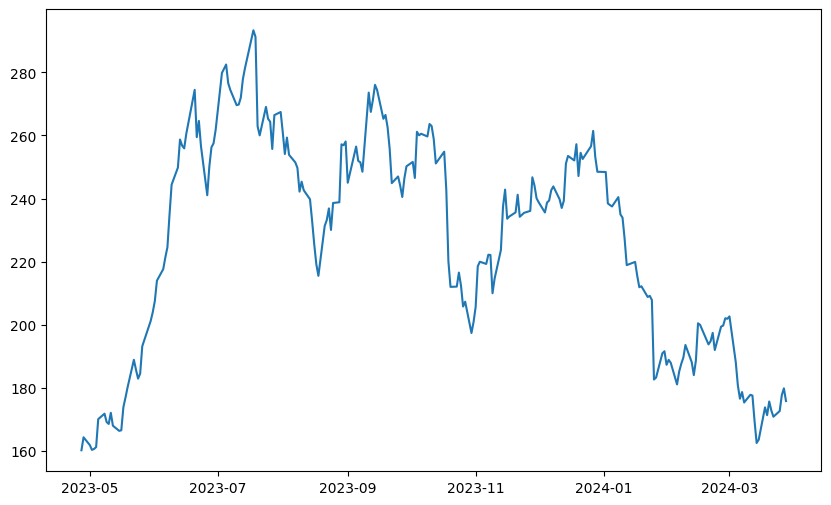

In [18]:
# plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), label='True Value')

# plt.plot(predictions, label='Predicted')


# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(stock_data.index[-232:], stock_data['Close'].tail(232), label='True Value')
plt.plot(stock_data.index[-232:], predictions, label='Predicted')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
